<h1><center>Прогнозирование вероятности оттока пользователей сети фитнес-центров</center></h1>

## Оглавление
* [Описание проекта](#first-bullet)
* [Описание данных](#second-bullet)
* [Шаг 1.  Загрузка данных](#third-bullet)
* [Шаг 2. Исследовательский анализ данных (EDA)](#fourth-bullet)
* [Шаг 3. Построим модель прогнозирования оттока клиентов](#fifth-bullet)
* [Шаг 4. Сделаем кластеризацию клиентов](#sixth-bullet)
* [Шаг 5.Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами](#seventh-bullet)

## Описание проекта <a class="anchor" id="first-bullet"></a>

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    - 1) выделить целевые группы клиентов;
    - 2) предложить меры по снижению оттока;
    - 3) определить другие особенности взаимодействия с клиентами.

## Описание данных  <a class="anchor" id="second-bullet"></a>

Датасет содержит данные на месяц до оттока и факт оттока на определённый месяц.

#### Набор данных включает следующие поля:
- `Churn` — факт оттока в текущем месяце;
- Текущие поля в датасете:
    - Данные клиента за предыдущий до проверки факта оттока месяц:
        - `gender` — пол;
        - `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
        - `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент
        — в таком случае фитнес-центр хранит информацию о работодателе клиента);
        - `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
        - `Phone` — наличие контактного телефона;
        - `Age` — возраст;
        - `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).
    - Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
        - `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
        - `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
        - `Group_visits` — факт посещения групповых занятий;
        - `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
        - `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
        - `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

## Шаг 1. Загрузка данных<a class="anchor" id="third-bullet"></a>

#### Импортируем все необходимые для работы библиотеки:

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

Загрузим данные и посмотрим на них:

In [2]:
gym_churn = pd.read_csv('gym_churn.csv')
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Приведем все названия столбцов к нижнему регистру для удобства:

In [3]:
gym_churn.columns

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
       'Churn'],
      dtype='object')

In [4]:
gym_churn.columns = ['gender','near_location','partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn']
gym_churn.head(5)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Данные загружены и готовы к предобработке и анализу.

## Шаг 2. Исследовательский анализ данных (EDA)<a class="anchor" id="fourth-bullet"></a>

#### 2.1 Посмотрим на датасет в целом:

In [5]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

На первый взгляд все хорошо - в данных нет пропусков и все типы данных определены верно. Посмотрим на средние значения и стандартные отклонения различных признаков.

#### 2.2 Проверим нет ли в данных дубликатов:

In [6]:
gym_churn.duplicated().sum()

0

Дубликаты отсутствуют.

In [7]:
gym_churn.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


В данных есть много столбцов (churn, gender, near_location, partner, promo_friends, phone, group_visits), где значений всего два - 0 или 1, по средним значениям и стандартному отклонению в них можно понять даже без графиков каких значений в них больше. 

Признак gender также представлен единицами и нулями. Без контекста не понятно что значит 1, а что 0, но посмотрев на некоторую статистику: https://www.outdoor.ru/formats/vodyanoe-prodvizhenie/, http://promoatlas.ru/reklama-v-fitnes-klubah-chto-nuzhno-znat/?lang=en - из нее понятно, что чаще всего большинство членов фитнес-клубов - женщины. Здесь у нас не такая уж большая разница в процентном соотношении, но для определенности все же примем 1 за женщин, а 0 за мужчин.

Итак, в выборке содержится 51% женщин и 49% мужчин.

84% клиентов проживают (или работают) в районе, где находится фитнес-центр.

48% клиентов - сотрудники компании-партнёра клуба (компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о их работодателе).

30% клиентов изначально пришли в клуб в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента).

У фитнес-клуба есть контактные телефоны 90% клиентов клуба.

41% клиентов посещает групповые занятия.

26% - отток клиентов в этом месяце.

#### Отдельно посмотрим на числовые признаки:

Age (возраст клиентов) колеблется от 18 до 41 года, в среднем составляя 29 лет (со стандартным отклонением в 3.2 года).

Lifetime (время с момента первого обращения в фитнес-центр) колеблется от 0 до 31 месяца, в среднем составляя 3.7 месяцев (со стандартным отклонением в 3.7 месяцев).

Contract_period (длительность текущего действующего абонемента) колеблется от 1 до 12 месяцев, в среднем составляя 4.6 месяца (со стандартным отклонением в 4.5 месяца).

Month_to_end_contract (срок до окончания текущего действующего абонемента) колеблется от 1 до 12 месяцев, в среднем составляя 4.3 месяца (со стандартным отклонением в 4.1 месяца).

Avg_class_frequency_total (средняя частота посещений в неделю за все время с начала действия абонемента) колеблется от 0 до 6 посещений в неделю, в среднем составляя 1.87 дней (со стандартным отклонением в 0.97 дней).

Avg_class_frequency_current_month (средняя частота посещений в неделю за предыдущий месяц) колеблется от 0 до 6 посещений в неделю, в среднем составляя 1.76 дней (со стандартным отклонением в 1.05 дней).

Avg_additional_charges_total (суммарная выручка от других услуг фитнес-центра) колеблется от 0.148 до 552.59, в среднем составляя 146.943 (со стандартным отклонением в 96.35).

#### 2.3 Посмотрим также на средние значения признаков этих двух групп - тех, кто ушел в отток и тех, кто остался.

In [8]:
gym_churn_groups = gym_churn.groupby('churn').mean()
gym_churn_groups.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


#### Больше всех видны различия в следующих признаках:

- contract_period (длительность текущего действующего абонемента) - 5.7 месяцев в среднем у тех, кто остался и 1.7 месяца в среднем у тех, кто ушел (различие в 3.35 раза).
- group_visits (факт посещения групповых занятий) 46% у тех, кто остался и 26% - у тех, кто ушел (различие в 1.76 раза).
- lifetime (время с момента первого обращения в фитнес-центр) - 4.7 месяцев и 0.99 месяца.
- avg_class_frequency_current_month (средняя частота посещений в неделю за предыдущий месяц) - 2.02 раза в среднем у тех, кто остался и 1.04 раза в среднем в неделю у тех, кто ушел.
- month_to_end_contract	(срок до окончания текущего действующего абонемента) - 5.2 месяца в среднем у тех, кто остался и 1.6 месяца в среднем у тех, кто ушел.
- partner (сотрудник компании-партнёра клуба) - отмечен в 53% у тех, кто остался и в 35% у тех, кто ушел.
- promo_friends (факт первоначальной записи в рамках акции «приведи друга») - 35% у тех, кто остался и 18% у тех, кто ушел.

#### Также имеют различия, но не такие большие:

- near_location (проживание или работа в районе, где находится фитнес-центр) - 87% - у тех, кто остался и 76% - у тех, кто ушел.
- avg_class_frequency_total (средняя частота посещений в неделю за все время с начала действия абонемента) - 2.02 раза в среднем у тех, кто остался и 1.47 раза в среднем в неделю у тех, кто ушел.
- Age (возраст клиентов) -  в среднем 29.9 лет у тех, кто остался и 26.9 лет у тех, кто ушел.
- Avg_additional_charges_total (суммарная выручка от других услуг фитнес-центра) - 158.4 в среднем у тех, кто остался и 115 в среднем у тех, кто ушел.

#### А следующие признаки довольно похожи у обоих групп:

- gender (пол клиентов) - и у группы, ушедшей в отток и у оставшихся клиентов - 51% женщин и 49% - мужчин.
- phone (телефон клиента) - у обоих групп 90% заполненности.

#### 2.4 Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

#### Построим графики для всех столбцов с числовыми значениями:

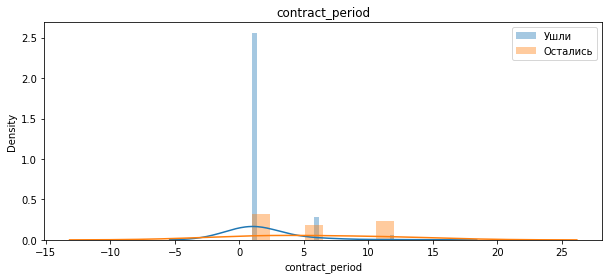

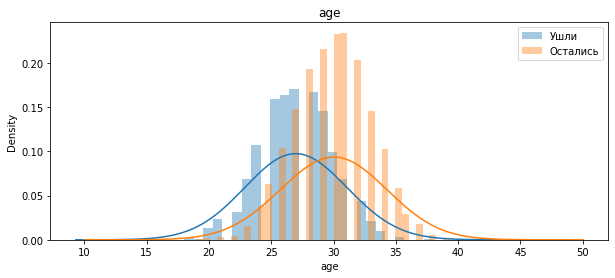

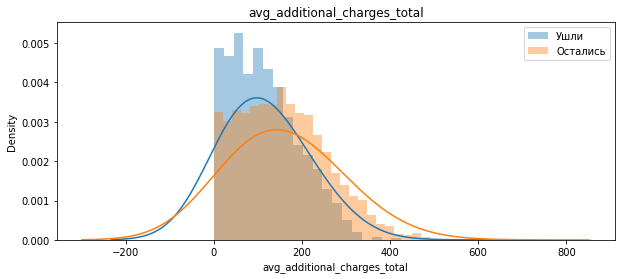

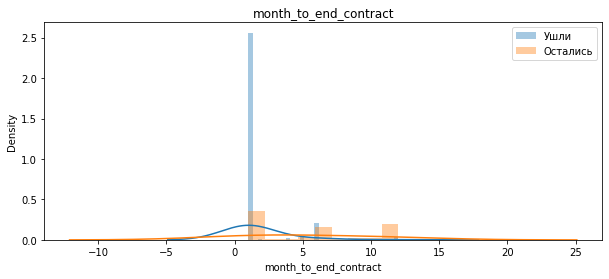

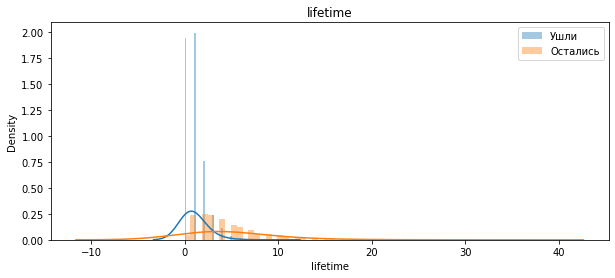

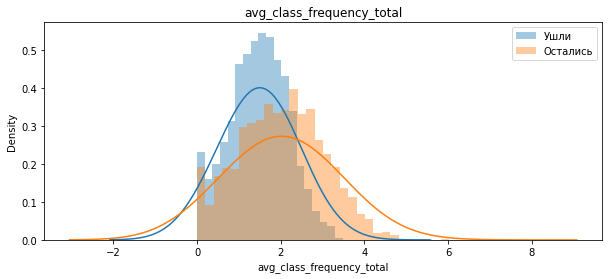

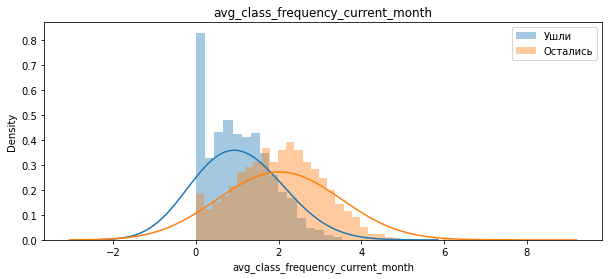

In [9]:
churn_1 = gym_churn.loc[gym_churn['churn'] == 1]
churn_0 = gym_churn.loc[gym_churn['churn'] == 0]
numeric_columns = ['contract_period', 'age','avg_additional_charges_total', 'month_to_end_contract',
                   'lifetime','avg_class_frequency_total', 'avg_class_frequency_current_month']

for column in numeric_columns:
    plt.figure(figsize = (10,4))
    plt.title(column)
    sns.distplot(churn_1[column], kde_kws = {'bw': 1}, label='Ушли')
    sns.distplot(churn_0[column], kde_kws = {'bw': 1}, label='Остались')
    plt.legend()
    plt.show()

#### Теперь построим графики для всех столбцов с категориальными значениями:

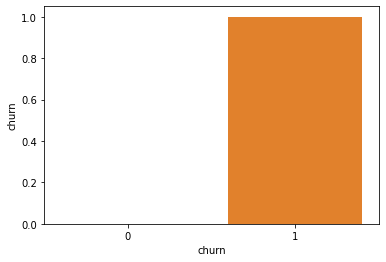

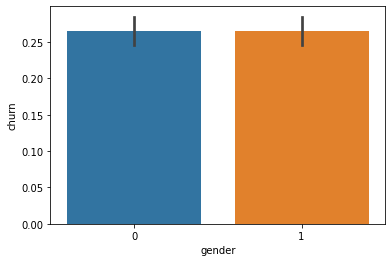

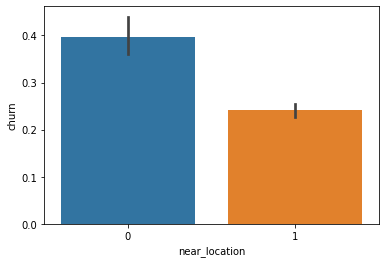

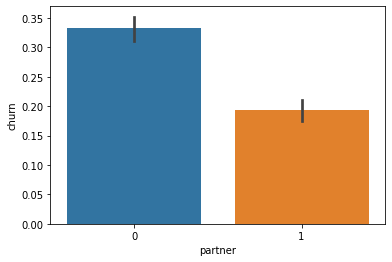

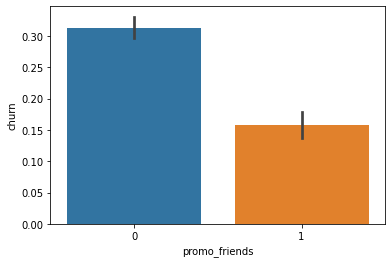

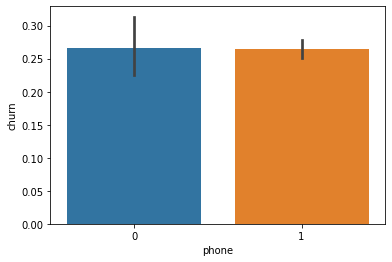

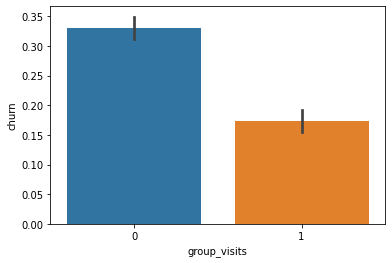

In [10]:
boolean_columns = ['churn', 'gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

for boolean_column in boolean_columns:
    plt.figure()
    sns.barplot(data = gym_churn, x = boolean_column, y = 'churn')

#### 2.5 Построим матрицу корреляций признаков:

<AxesSubplot:title={'center':'Correlation between variables'}>

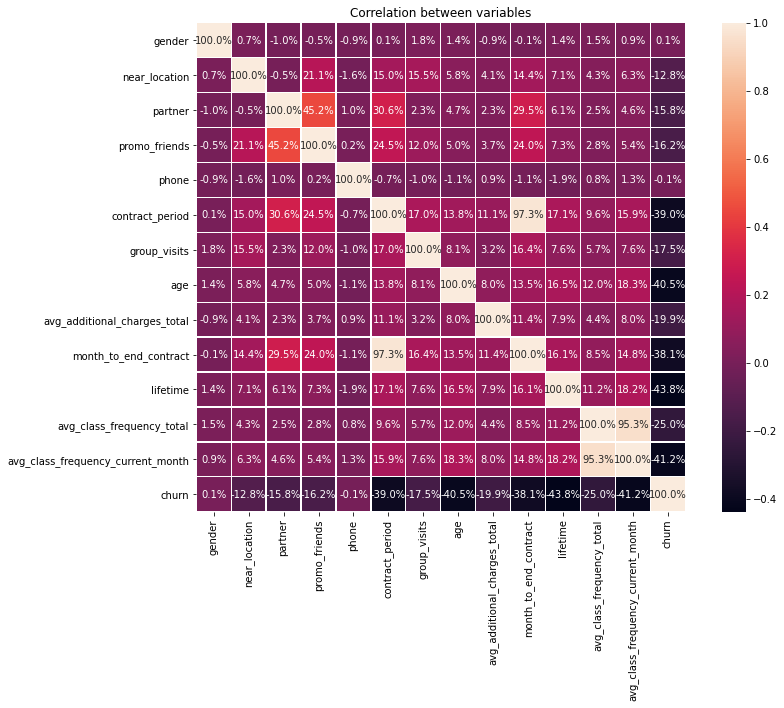

In [11]:
cm = gym_churn.corr()
plt.figure(figsize=(13, 9))
plt.title('Correlation between variables')
sns.heatmap(cm, annot = True, fmt='.1%', linewidths=0.2, square=True)

Из тепловой карты видно, что параметры Contract_period (длительность текущего действующего абонемента) и Month_to_end_contract (то сколько месяцев осталось до конца действия текущего абонемента) очень сильно коррелируют (97.3%).

Также сильно коррелируют параметры Avg_class_frequency_total (средняя частота посещений в неделю за все время с начала действия абонемента) и Avg_class_frequency_current_month (средняя частота посещений в неделю за предыдущий месяц). И то и то очень логично.

 Уберем по одному из каждой пары сильно коррелирующих признаков:

In [12]:
gym_churn_filtered = gym_churn.drop('month_to_end_contract', axis=1) 
gym_churn_filtered = gym_churn_filtered.drop('avg_class_frequency_current_month', axis=1) 
gym_churn_filtered.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
0,1,1,1,1,0,6,1,29,14.227470,3,0.020398,0
1,0,1,0,0,1,12,1,31,113.202938,7,1.922936,0
2,0,1,1,0,1,1,0,28,129.448479,2,1.859098,0
3,0,1,1,1,1,12,1,33,62.669863,2,3.205633,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.113884,0


### Вывод


Были рассмотрены средние значения двух категорий клиентов - тех, кто ушел из фитнес-центра и тех, кто остался его клиентом, а также построены графики и тепловая карта корреляций.

Больше всех видны различия в следующих признаках:

- contract_period (длительность текущего действующего абонемента) - 5.7 месяцев в среднем у тех, кто остался и 1.7 месяца в среднем у тех, кто ушел (различие в 3.35 раза).
- group_visits (факт посещения групповых занятий) 46% у тех, кто остался и 26% - у тех, кто ушел (различие в 1.76 раза).
- lifetime (время с момента первого обращения в фитнес-центр) - 4.7 месяцев и 0.99 месяца.
- avg_class_frequency_current_month (средняя частота посещений в неделю за предыдущий месяц) - 2.02 раза в среднем у тех, кто остался и 1.04 раза в среднем в неделю у тех, кто ушел.
- month_to_end_contract	(срок до окончания текущего действующего абонемента) - 5.2 месяца в среднем у тех, кто остался и 1.6 месяца в среднем у тех, кто ушел.
- partner (сотрудник компании-партнёра клуба) - отмечен в 53% у тех, кто остался и в 35% у тех, кто ушел.
- promo_friends (факт первоначальной записи в рамках акции «приведи друга») - 35% у тех, кто остался и 18% у тех, кто ушел.

Также имеют различия, но не такие большие:

- near_location (проживание или работа в районе, где находится фитнес-центр) - 87% - у тех, кто остался и 76% - у тех, кто ушел.
- avg_class_frequency_total (средняя частота посещений в неделю за все время с начала действия абонемента) - 2.02 раза в среднем у тех, кто остался и 1.47 раза в среднем в неделю у тех, кто ушел.
- Age (возраст клиентов) -  в среднем 29.9 лет у тех, кто остался и 26.9 лет у тех, кто ушел.
- Avg_additional_charges_total (суммарная выручка от других услуг фитнес-центра) - 158.4 в среднем у тех, кто остался и 115 в среднем у тех, кто ушел.

А следующие признаки довольно похожи у обоих групп:

- gender (пол клиентов) - и у группы, ушедшей в отток и у оставшихся клиентов - 51% женщин и 49% - мужчин.
- phone (телефон клиента) - у обоих групп 90% заполненности.

Также после построения тепловой карты корреляций признаков - был создан новый датасет, в котором были удалены 2 сильно коррелирующих с 2-мя другими признака. 

## Шаг 3. Построим модель прогнозирования оттока клиентов <a class="anchor" id="fifth-bullet"></a>

#### 3.1 Разобьем данные на обучающую и валидационную выборку:

In [13]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn_filtered.drop(columns = ['churn'])
y = gym_churn_filtered['churn']

# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

#### 3.2 Обучим модель на train-выборке двумя способами:
- 1) логистической регрессией

In [14]:
model_1 = LogisticRegression(random_state = 0)
model_1.fit(X_train_st, y_train)
y_pred = model_1.predict(X_test_st)
acc_1 = metrics.accuracy_score(y_test, y_pred)
prec_1 = metrics.precision_score(y_test, y_pred)
recall_1 = metrics.recall_score(y_test, y_pred)
print('Accuracy первой модели: {}'.format(acc_1))
print()
print('Precision первой модели: {}'.format(prec_1))
print()
print('Recall первой модели: {}'.format(recall_1))

Accuracy первой модели: 0.89875

Precision первой модели: 0.7881773399014779

Recall первой модели: 0.8080808080808081


- 2) случайным лесом

In [15]:
model_2 = RandomForestClassifier(random_state = 0)
model_2.fit(X_train_st, y_train)
y_pred2 = model_2.predict(X_test_st)
 
acc_2 = metrics.accuracy_score(y_test, y_pred2)
prec_2 = metrics.precision_score(y_test, y_pred2)
recall_2 = metrics.recall_score(y_test, y_pred2)
print('Accuracy второй модели: {}'.format(acc_2))
print()
print('Precision второй модели: {}'.format(prec_2))
print()
print('Recall второй модели: {}'.format(recall_2))


# model_2 = RandomForestClassifier(random_state = 0, n_estimators = 10000)
# model_2.fit(X_train_st, y_train)
# y_pred2 = model_2.predict(X_test_st)
 
# acc_2 = metrics.accuracy_score(y_test, y_pred2)
# prec_2 = metrics.precision_score(y_test, y_pred2)
# recall_2 = metrics.recall_score(y_test, y_pred2)
# print('Accuracy второй модели: {}'.format(acc_2))
# print()
# print('Precision второй модели: {}'.format(prec_2))
# print()
# print('Recall второй модели: {}'.format(recall_2))

Accuracy второй модели: 0.89

Precision второй модели: 0.7864583333333334

Recall второй модели: 0.7626262626262627


#### Вывод 

Из сравнения параметров видно, что модель логистической регрессии (LogisticRegression) выигрывает по всем пунктам, поэтому я бы советовала использовать ее.

Хотя мы можем попробовать поменять параметр n_estimators у RandomForestClassifier на 10 000, например, и он будет по accuracy уже почти такой же как у логистической регрессии, а по precission выигрывать (по recall все еще проигрывать), но RandomForestClassifier будет гораздо медленнее, поэтому при прочих равных я бы использовала LogisticRegression.

## Шаг 4. Сделаем кластеризацию клиентов <a class="anchor" id="sixth-bullet"></a>

#### 4. 1 Стандартизируем данные (матрицу X):

In [16]:
sc = StandardScaler()
X_st = sc.fit_transform(X)

#### 4.2 Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму:

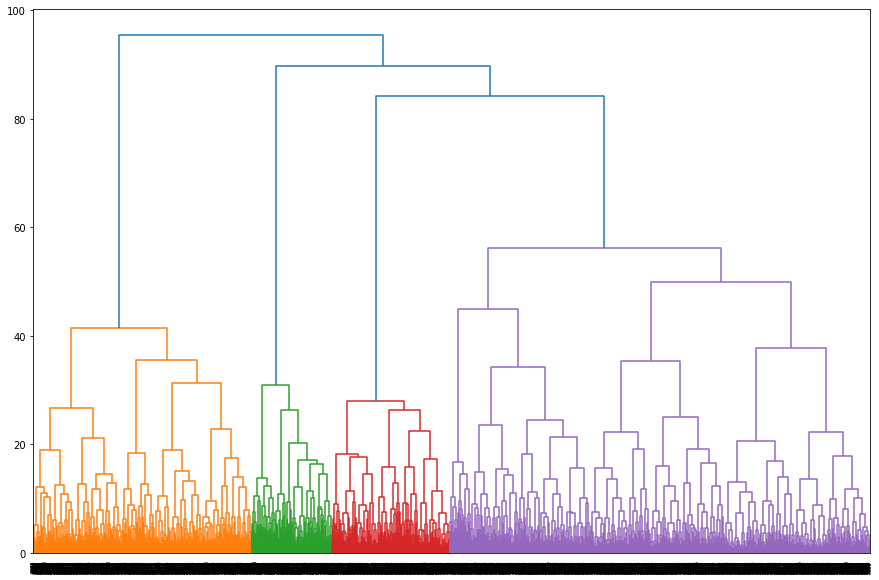

In [17]:
linked = linkage(X_st, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

По дендограмме видно, что алгоритм предлагает нам разделить все данные на 4 кластера (выделенные разными цветами на дендограмме).

#### 4.3 Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Договоримся за число кластеров принять n=5 (этот вариант был взят  для согласованности результатов с работами других студентов)

In [18]:
km = KMeans(n_clusters = 5, random_state = 0) # задаём число кластеров, равное 5
labels = km.fit_predict(X_st) # применяем алгоритм к данным и формируем вектор кластеров

In [19]:
gym_churn_filtered['cluster'] = labels # сохраним метки кластера в отдельный столбец нашего датасета

#### 4.4 Посмотрим на средние значения признаков для кластеров

In [20]:
gym_churn_filtered.groupby(['cluster']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
cluster,,,,,,,,,,,,
0,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,3.060606,1.770413,0.399287
1,0.488571,0.995238,0.955238,0.892381,1.0,7.660952,0.458095,29.543810,155.861428,4.380952,1.978963,0.120952
2,0.505300,1.000000,0.238516,0.059187,1.0,2.819788,0.000000,28.770318,143.383993,3.343640,1.800647,0.381625
3,0.544202,1.000000,0.250287,0.079219,1.0,4.528129,1.000000,29.536165,148.088897,3.761194,1.941342,0.200918
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839


Из рассмотрения средних значений, сильно выбиваются следующие:

- у нулевого кластера среднее значение near_location равно нулю, а у второго и третьего кластера - единице.
- у первого кластера высокий процент людей, пришедших от партнеров - 95%.
- у четвертого кластера у всех не заполнен телефон (phone).
- у второго кластера нулевое посещение групповых занятий, а у 3-ого - 100%.
- самый низкий churn rate у первого кластера.

#### 4.5 Построим распределения признаков для кластеров

Построим графики для столбцов с численными данными:

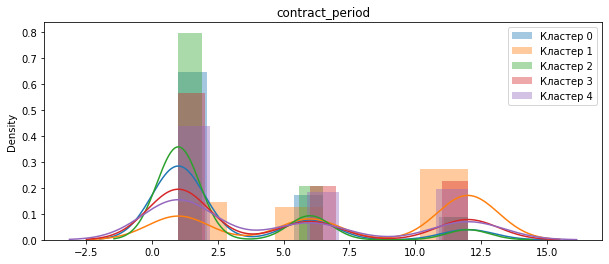

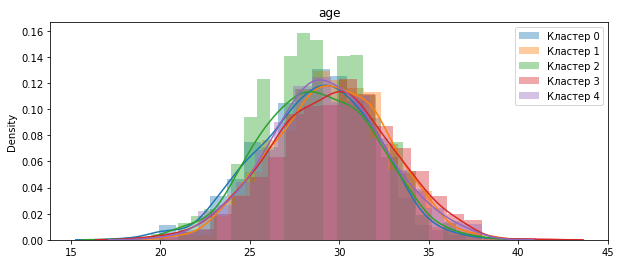

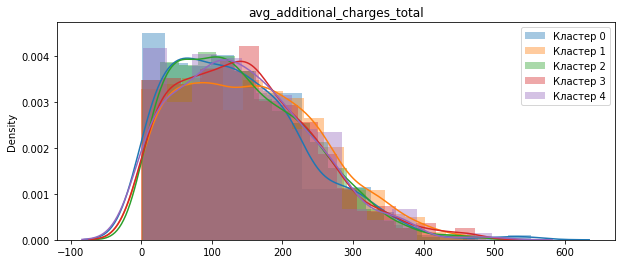

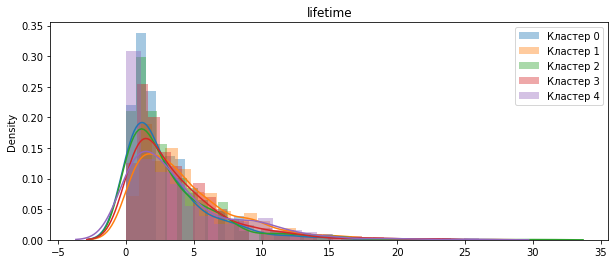

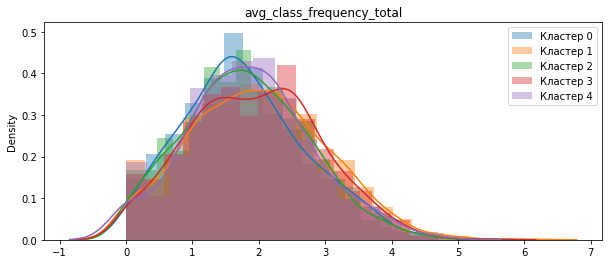

In [21]:
numeric_columns_new = ['contract_period', 'age','avg_additional_charges_total','lifetime','avg_class_frequency_total']

for column in numeric_columns_new:
    plt.figure(figsize = (10,4))
    for i in range(5):
        cluster = gym_churn_filtered.loc[gym_churn_filtered['cluster'] == i]
        sns.distplot(cluster[[column]], hist = True, kde = True, rug = False, label = 'Кластер ' + str(i))
    plt.legend()
    plt.title(column)
    plt.show()

Графики displot накладываются друг на друга, что мешает анализу, поэтому добавим также визуализацию с помощью boxplot:

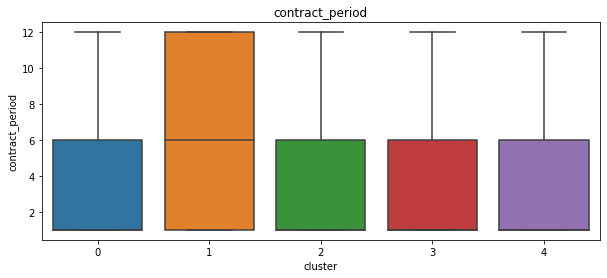

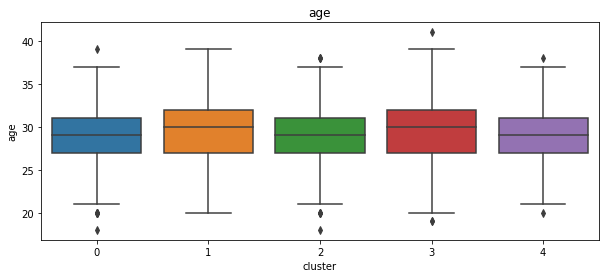

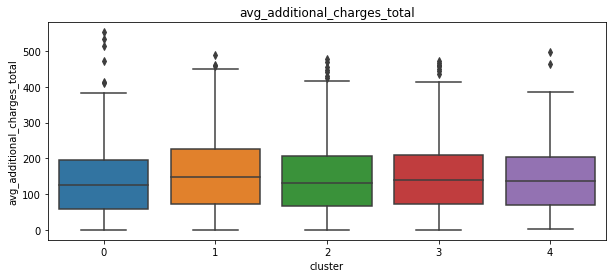

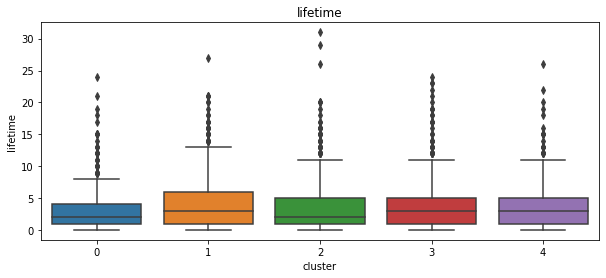

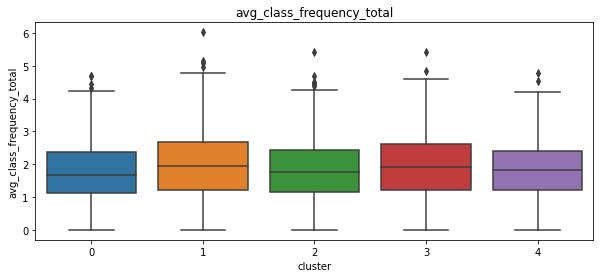

In [22]:
numeric_columns_new = ['contract_period', 'age','avg_additional_charges_total','lifetime','avg_class_frequency_total']

for column in numeric_columns_new:
    plt.figure(figsize = (10,4))
#   cluster = gym_churn_filtered.loc[gym_churn_filtered['cluster'] == i]
    sns.boxplot(x = 'cluster', y = column, data = gym_churn_filtered) # label = 'Кластер ' + str(i)
#   plt.legend()
    plt.title(column)
    plt.show()

Построим графики для столбцов с категориальными данными:

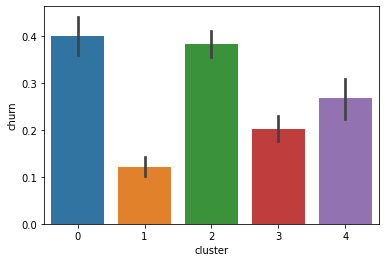

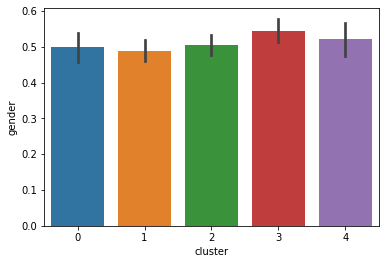

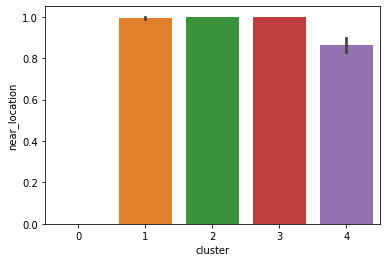

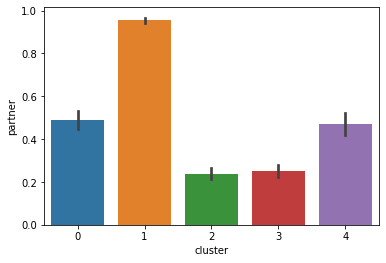

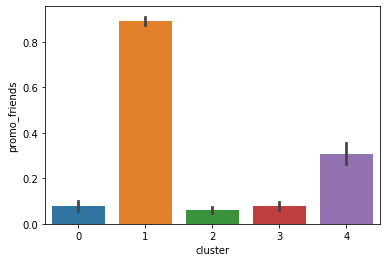

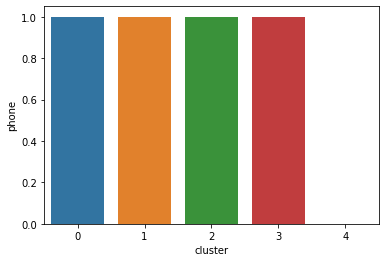

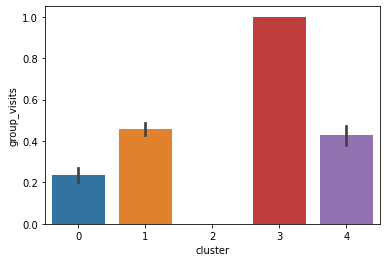

In [23]:
for boolean_column in boolean_columns:
    plt.figure()
    sns.barplot(data = gym_churn_filtered, x = 'cluster', y = boolean_column)
    plt.show()

#### 4.6 Для каждого полученного кластера посчитаем долю оттока.

In [24]:
gym_churn_filtered.groupby(['cluster'])['churn'].mean()

cluster
0    0.399287
1    0.120952
2    0.381625
3    0.200918
4    0.266839
Name: churn, dtype: float64

У кластеров сильно разные доли оттока и самым надежным из них можно считать первый кластер, у него процент оттока - 12%, следующий после него по надежности - третий кластер, у него процент оттока 20%. А самый ненадежный кластер - нулевой, у него процент оттока - 39%, сразу за ним идет второй кластер с 38% оттока.

Чтобы дать рекомендации по работе с клиентами для их удержания, можно предположить, что нужно избегать того, что характеризует высокий отток (то есть то, что содержит кластер 0) и делать больше того, что характеризует низкий отток (то есть то, что характерно для кластера 1).

Посмотрев на распределения числовых и категориальных признаков в этих кластерах, можно сделать вывод, что:

- Для кластера 0 (высокого оттока) характерно: тратят меньше всех денег на дополнительные услуги центра; высокий процент клиентов с низким средним кол-вом посещений в неделю (медиана в 1.5); средний возраст клиентов около 28 лет; все клиенты живут не рядом.

- Для кластера 1 (низкого оттока) характерно: большое кол-во длинных контрактов (10-12 месяцев); средний возраст клиентов около 31 (такой же, как у третьего кластера и выше, чем у всех остальных кластеров; высокий процент клиентов, среднее кол-во посещений центра в неделю у которых выше, чем у остальных кластеров (медиана чуть выше 2); почти все клиенты живут рядом; почти все клиенты - сотрудники компании-партнёра клуба; 89% - изначально пришли по акции "приведи друга"

## Шаг 5. Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами <a class="anchor" id="seventh-bullet"></a>

### Основные выводы:

1) В начале анализа были рассмотрены средние значения двух категорий клиентов - тех, кто ушел из фитнес-центра и тех, кто остался его клиентом, а также построены графики и тепловая карта корреляций.

Больше всех видны различия в следующих признаках:

- contract_period (длительность текущего действующего абонемента) - 5.7 месяцев в среднем у тех, кто остался и 1.7 месяца в среднем у тех, кто ушел (различие в 3.35 раза).
- group_visits (факт посещения групповых занятий) 46% у тех, кто остался и 26% - у тех, кто ушел (различие в 1.76 раза).
- lifetime (время с момента первого обращения в фитнес-центр) - 4.7 месяцев и 0.99 месяца.
- avg_class_frequency_current_month (средняя частота посещений в неделю за предыдущий месяц) - 2.02 раза в среднем у тех, кто остался и 1.04 раза в среднем в неделю у тех, кто ушел.
- month_to_end_contract (срок до окончания текущего действующего абонемента) - 5.2 месяца в среднем у тех, кто остался и 1.6 месяца в среднем у тех, кто ушел.
- partner (сотрудник компании-партнёра клуба) - отмечен в 53% у тех, кто остался и в 35% у тех, кто ушел.
- promo_friends (факт первоначальной записи в рамках акции «приведи друга») - 35% у тех, кто остался и 18% у тех, кто ушел.

Также имеют различия, но не такие большие:

- near_location (проживание или работа в районе, где находится фитнес-центр) - 87% - у тех, кто остался и 76% - у тех, кто ушел.
- avg_class_frequency_total (средняя частота посещений в неделю за все время с начала действия абонемента) - 2.02 раза в среднем у тех, кто остался и 1.47 раза в среднем в неделю у тех, кто ушел.
- Age (возраст клиентов) - в среднем 29.9 лет у тех, кто остался и 26.9 лет у тех, кто ушел.
- Avg_additional_charges_total (суммарная выручка от других услуг фитнес-центра) - 158.4 в среднем у тех, кто остался и 115 в среднем у тех, кто ушел.

А следующие признаки довольно похожи у обоих групп:

- gender (пол клиентов) - и у группы, ушедшей в отток и у оставшихся клиентов - 51% женщин и 49% - мужчин.
- phone (телефон клиента) - у обоих групп 90% заполненности.

Также после построения тепловой карты корреляций признаков был создан новый датасет, в котором были удалены 2 сильно коррелирующих с 2-мя другими признака.

2) Далее была построена модель прогнозирования оттока клиентов, для этого: данные были разбиты на обучающую и валидационную выборку функцией, на train-выборке была обучите модель методом логистической регресси и методом случайного леса.
Были оценены метрики accuracy, precision и recall для обеих моделей на валидационной выборке.
Из сравнения параметров был сделан вывод, что модель логистической регрессии (LogisticRegression) выигрывает по всем пунктам, поэтому логичнее использовать ее.

3) Далее была произведена кластеризация клиентов:
Для этого была построена матрицу расстояний и нарисована дендрограмма. На ее основании предположено, что оптимальное кол-во клстеров - 4. 

После чего была обучена модель кластеризации на основании алгоритма K-Means и спрогнозированы кластеры клиентов (число кластеров по умолчанию приняли за 5).

По средним значениям признаков в кластерах можно сказать:
- у нулевого кластера среднее значение near_location равно нулю, а у второго и третьего кластера - единице.
- у первого кластера высокий процент людей, пришедших от партнеров - 95%.
- у четвертого кластера у всех не заполнен телефон (phone).
- у второго кластера нулевое посещение групповых занятий, а у 3-ого - 100%.
- самый низкий churn rate у первого кластера.

Также были рассмотрены средние значения и построены распределения признаков для кластеров, для каждого полученного кластера посчитана долю оттока. На основе графиков и полученных данных сделан вывод:

У кластеров сильно разные доли оттока и самым надежным из них можно считать первый кластер, у него процент оттока - 12%, следующий после него по надежности - третий кластер, у него процент оттока 20%. А самый ненадежный кластер - нулевой, у него процент оттока - 39%.

Чтобы дать рекомендации по работе с клиентами для их удержания, можно предположить, что нужно избегать того, что характеризует высокий отток (то есть то, что содержит кластер 0) и делать больше того, что характеризует низкий отток (то есть то, что характерно для кластера 1).

Посмотрев на распределения числовых и категориальных признаков в этих кластерах, можно сделать вывод, что:

- Для кластера 0 (высокого оттока) характерно: тратят меньше всех денег на дополнительные услуги центра; высокий процент клиентов с низким средним кол-вом посещений в неделю (медиана в 1.5); средний возраст клиентов около 28 лет; все клиенты живут не рядом.

- Для кластера 1 (низкого оттока) характерно: большое кол-во длинных контрактов (10-12 месяцев); средний возраст клиентов около 31 (такой же, как у третьего кластера и выше, чем у всех остальных кластеров; высокий процент клиентов, среднее кол-во посещений центра в неделю у которых выше, чем у остальных кластеров (медиана чуть выше 2); почти все клиенты живут рядом; почти все клиенты - сотрудники компании-партнёра клуба; 89% - изначально пришли по акции "приведи друга"

### Рекомендации:

Мы можем сделать вывод, что люди, остающиеся в фитнес-центре долго часто изначально приходят туда по рекомендации друга или фирмы-партнера, возможно эти же друзья и коллеги стимулируют клиентов чаще посещать фитнес-центр, тратить в нем больше денег на дополнительные услуги и посещать групповые занятия. Поэтому будет хорошей идеей придумывать больше подобных акций, направленных на привлечение людей в центр за счет специальных программ/скидок, это будет увеличивать кол-во клиентов, а также возможно посещаемость и дополнительный заработок на различных услугах центра. И возможно тогда люди, которые сейчас быстро уходят, тоже будут чаще приходить, потому что им будет интереснее ходить в клуб с друзьями.

Также видно, что часто из клуба уходят те, кто живет/работает не близко - этот критерий сложно улучшить, но можно придумать какие-нибудь партнерские программы с другими клубами близко с домом/работой этого клиента или стимулируя их приезд специальными уникальными услугами, которые сложно найти где-то еще.

Также из статистики видно, что в отток часто уходят наиболее молодые клиенты клуба, возможно нужно придумать для них отдельные способы удержания: какие-то трендовые виды нагрузок, интересные челенджи в социальных сетях, специальные скидки для студентов на длинные абонементы и тд.